<a href="https://colab.research.google.com/github/karthik1946/01_c/blob/main/dl_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd

# Set display options to show more columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

file_names = ["/content/drive/MyDrive/S-1/Train/1.txt", "/content/drive/MyDrive/S-1/Train/2.txt", "/content/drive/MyDrive/S-1/Train/3.txt", "/content/drive/MyDrive/S-1/Train/4.txt", "/content/drive/MyDrive/S-1/Train/5.txt", "/content/drive/MyDrive/S-1/Train/6.txt", "/content/drive/MyDrive/S-1/Train/7.txt", "/content/drive/MyDrive/S-1/Train/8.txt"]

concatenated_data = pd.DataFrame()

for file_name in file_names:
    data = pd.read_csv(file_name, delimiter=',', header=None)
    concatenated_data = pd.concat([concatenated_data, data], axis=0)

concatenated_data.reset_index(drop=True, inplace=True)

concatenated_data.shape


(194369, 38)

In [3]:
pip install tensorflow

In [4]:
import tensorflow

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [6]:
import pandas as pd

# Set display options to show more columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

file_names = ["/content/drive/MyDrive/S-1/Test_Label/1.txt",
              "/content/drive/MyDrive/S-1/Test_Label/2.txt",
              "/content/drive/MyDrive/S-1/Test_Label/3.txt",
              "/content/drive/MyDrive/S-1/Test_Label/4.txt",
              "/content/drive/MyDrive/S-1/Test_Label/5.txt",
              "/content/drive/MyDrive/S-1/Test_Label/6.txt",
              "/content/drive/MyDrive/S-1/Test_Label/7.txt"]

X_test = pd.DataFrame()

for file_name in file_names:
    data = pd.read_csv(file_name, delimiter=',', header=None)
    X_test = pd.concat([X_test, data], axis=0)

X_test.reset_index(drop=True, inplace=True)

print("Shape of predictions:", X_test.shape)



Shape of predictions: (170675, 1)


In [8]:
# Count occurrences of 1s and 0s
label_counts = X_test[0].value_counts()

# Calculate percentage
label_percentages = (label_counts / len(X_test)) * 100

# Display counts and percentages
print("Counts of labels:")
print(label_counts)

print("\nPercentages of labels:")
print(label_percentages)


Counts of labels:
0    159696
1     10979
Name: 0, dtype: int64

Percentages of labels:
0    93.567306
1     6.432694
Name: 0, dtype: float64


In [7]:
import pandas as pd

# Set display options to show more columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

file_names = ["/content/drive/MyDrive/S-1/Test/1.txt", "/content/drive/MyDrive/S-1/Test/2.txt", "/content/drive/MyDrive/S-1/Test/3.txt", "/content/drive/MyDrive/S-1/Test/4.txt", "/content/drive/MyDrive/S-1/Test/5.txt", "/content/drive/MyDrive/S-1/Test/6.txt", "/content/drive/MyDrive/S-1/Test/7.txt"]

X_data = pd.DataFrame()

for file_name in file_names:
    data = pd.read_csv(file_name, delimiter=',', header=None)
    X_data = pd.concat([X_data, data], axis=0)

X_data.reset_index(drop=True, inplace=True)

X_data.shape


(170675, 38)

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming concatenated_data is your DataFrame with 38 sensor columns
multivariate_data = concatenated_data.copy()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(multivariate_data)

# Define sequences for training
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length, :]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 10  # Adjust based on your requirements
X = create_sequences(scaled_data, sequence_length)

# Split the data into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.2, shuffle=False)

# Build the LSTM model for binary classification
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Use binary_crossentropy for binary classification

# Define a ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint("best_model_weights.h5", save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
epochs = 3  # Adjust the number of epochs based on your requirements
best_val_accuracy = 0.0
best_threshold = 0.5  # Initial threshold for binary classification
for epoch in range(epochs):
    history = model.fit(X_train, np.ones(X_train.shape[0]), epochs=1, batch_size=32, validation_data=(X_val, np.ones(X_val.shape[0])), callbacks=[checkpoint], verbose=1)

    # Calculate validation accuracy after each epoch
    predictions_val = model.predict(X_val)
    predictions_val_binary = (predictions_val > best_threshold).astype(int)

    validation_accuracy = np.sum(predictions_val_binary.flatten() == np.ones(X_val.shape[0])) / X_val.shape[0]

    # Adjust threshold dynamically based on validation accuracy
    if validation_accuracy > best_val_accuracy:
        best_val_accuracy = validation_accuracy
        best_threshold = 0.5  # In binary classification, threshold is typically 0.5

    print(f"Epoch {epoch + 1}/{epochs} - Validation Accuracy: {validation_accuracy * 100:.2f}% - Threshold: {best_threshold:.4f}")


4855/4859 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9996
Epoch 1: val_loss improved from inf to 0.73337, saving model to best_model_weights.h5
1215/1215 [==============================] - 6s 4ms/step
Epoch 1/3 - Validation Accuracy: 62.98% - Threshold: 0.5000
4857/4859 [============================>.] - ETA: 0s - loss: 1.4730e-06 - accuracy: 1.0000
Epoch 1: val_loss did not improve from 0.73337
1215/1215 [==============================] - 4s 3ms/step
Epoch 2/3 - Validation Accuracy: 62.83% - Threshold: 0.5000
4854/4859 [============================>.] - ETA: 0s - loss: 1.5093e-07 - accuracy: 1.0000
Epoch 1: val_loss did not improve from 0.73337
1215/1215 [==============================] - 5s 4ms/step
Epoch 3/3 - Validation Accuracy: 62.52% - Threshold: 0.5000


In [10]:
def find_best_threshold(predictions, threshold_candidates):
    best_f1_score = 0
    best_threshold = 0

    for threshold in threshold_candidates:
        binary_predictions = (predictions > threshold).astype(int)
        # Assuming you have ground truth labels for validation set (y_val)
        true_positive = np.sum((binary_predictions == 1) & (y_val == 1))
        false_positive = np.sum((binary_predictions == 1) & (y_val == 0))
        false_negative = np.sum((binary_predictions == 0) & (y_val == 1))

        precision = true_positive / (true_positive + false_positive + 1e-10)
        recall = true_positive / (true_positive + false_negative + 1e-10)
        f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

        if f1_score > best_f1_score:
            best_f1_score = f1_score
            best_threshold = threshold

    return best_threshold


In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming concatenated_data is your DataFrame with 38 sensor columns
multivariate_data = concatenated_data.copy()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(multivariate_data)

# Define sequences for training
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length, :]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 10  # Adjust based on your requirements
X = create_sequences(scaled_data, sequence_length)

# Split the data into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.2, shuffle=False)

# Build the LSTM model for binary classification
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])  # Use mean squared error for regression

# Define a ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint("best_model_weights.h5", save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
epochs = 4  # Adjust the number of epochs based on your requirements
best_threshold = 0.5  # Initial threshold for binary classification
for epoch in range(epochs):
    history = model.fit(X_train, np.ones(X_train.shape[0]), epochs=1, batch_size=16, validation_data=(X_val, np.ones(X_val.shape[0])), callbacks=[checkpoint], verbose=1)

    # Calculate validation accuracy after each epoch
    predictions_val = model.predict(X_val)
    predictions_val_binary = (predictions_val > best_threshold).astype(int)

    # Adjust threshold dynamically based on validation predictions
    threshold_candidates = np.linspace(0, 1, 100)


    # Assuming you want to print accuracy without ground truth labels
    validation_accuracy = np.sum(predictions_val_binary.flatten() == np.ones(X_val.shape[0])) / X_val.shape[0]

    print(f"Epoch {epoch + 1}/{epochs} - Validation Accuracy: {validation_accuracy * 100:.2f}% - Threshold: {best_threshold:.4f}")


9717/9718 [============================>.] - ETA: 0s - loss: 2.9245e-04 - accuracy: 0.9998
Epoch 1: val_loss improved from inf to 0.13592, saving model to best_model_weights.h5
1215/1215 [==============================] - 13s 9ms/step
Epoch 1/4 - Validation Accuracy: 74.89% - Threshold: 0.5000
9718/9718 [==============================] - ETA: 0s - loss: 4.4384e-09 - accuracy: 1.0000
Epoch 1: val_loss did not improve from 0.13592
1215/1215 [==============================] - 12s 10ms/step
Epoch 2/4 - Validation Accuracy: 75.08% - Threshold: 0.5000
9718/9718 [==============================] - ETA: 0s - loss: 1.5561e-10 - accuracy: 1.0000
Epoch 1: val_loss did not improve from 0.13592
1215/1215 [==============================] - 11s 9ms/step
Epoch 3/4 - Validation Accuracy: 75.35% - Threshold: 0.5000
9717/9718 [============================>.] - ETA: 0s - loss: 4.6907e-11 - accuracy: 1.0000
Epoch 1: val_loss did not improve from 0.13592
1215/1215 [==============================] - 10s 8ms/s

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_curve, auc

# Assuming concatenated_data is your DataFrame with 38 sensor columns
multivariate_data = concatenated_data.copy()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(multivariate_data)

# Define sequences for training
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        seq = data[i:i + sequence_length, :]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 10  # Adjust based on your requirements
X = create_sequences(scaled_data, sequence_length)

# Split the data into training and validation sets
X_train, X_val = train_test_split(X, test_size=0.2, shuffle=False)

# Build the LSTM model for binary classification
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])  # Use mean squared error for regression

# Define a ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint("best_model_weights.h5", save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model
epochs = 4  # Adjust the number of epochs based on your requirements
best_threshold = 0.5  # Initial threshold for binary classification
for epoch in range(epochs):
    history = model.fit(X_train, np.ones(X_train.shape[0]), epochs=1, batch_size=16, validation_data=(X_val, np.ones(X_val.shape[0])), callbacks=[checkpoint], verbose=1)

    # Calculate validation accuracy after each epoch
    predictions_val = model.predict(X_val)

    try:
        fpr, tpr, thresholds = roc_curve(np.ones(X_val.shape[0]), predictions_val)

        # Find threshold that maximizes Youden's J statistic
        optimal_idx = np.argmax(tpr - fpr)
        best_threshold = thresholds[optimal_idx]
    except ValueError:
        # Handle the case where ROC curve calculation is not possible
        pass

    predictions_val_binary = (predictions_val > best_threshold).astype(int)

    # Assuming you want to print accuracy without ground truth labels
    validation_accuracy = np.sum(predictions_val_binary.flatten() == np.ones(X_val.shape[0])) / X_val.shape[0]

    print(f"Epoch {epoch + 1}/{epochs} - Validation Accuracy: {validation_accuracy * 100:.2f}% - Threshold: {best_threshold:.4f}")


9717/9718 [============================>.] - ETA: 0s - loss: 2.6326e-04 - accuracy: 0.9999
Epoch 1: val_loss improved from inf to 0.26447, saving model to best_model_weights.h5
1215/1215 [==============================] - 15s 11ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Epoch 1/4 - Validation Accuracy: 0.00% - Threshold: 2.0000
9718/9718 [==============================] - ETA: 0s - loss: 2.4944e-09 - accuracy: 1.0000
Epoch 1: val_loss did not improve from 0.26447
1215/1215 [==============================] - 14s 11ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Epoch 2/4 - Validation Accuracy: 0.00% - Threshold: 2.0000
9717/9718 [============================>.] - ETA: 0s - loss: 1.5206e-10 - accuracy: 1.0000
Epoch 1: val_loss did not improve from 0.26447
1215/1215 [==============================] - 13s 10ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


Epoch 3/4 - Validation Accuracy: 0.00% - Threshold: 2.0000
9718/9718 [==============================] - ETA: 0s - loss: 5.3728e-11 - accuracy: 1.0000
Epoch 1: val_loss did not improve from 0.26447
1215/1215 [==============================] - 12s 10ms/step
Epoch 4/4 - Validation Accuracy: 0.00% - Threshold: 2.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [34]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming X_data is your DataFrame with 38 sensor columns
X_data_np = X_data.to_numpy()

# Standardize the test data using the same scaler
scaled_X_data = scaler.fit_transform(X_data_np)

# Create sequences for the test data
X_data_sequences = create_sequences(scaled_X_data, sequence_length)

# Use the trained model to predict sequences on the test data
predictions_data = model.predict(X_data_sequences)

# Apply a threshold of 0.5 for binary classification
predictions_data_binary = (predictions_data > 0.5).astype(int)

# Flatten the predictions for comparison
predictions_data_binary_flat = predictions_data_binary.flatten()

# Flatten the actual labels for comparison
actual_labels_flat = X_test.to_numpy().flatten()  # Assuming X_test is the correct label for X_data_np
actual_labels_flat = actual_labels_flat[:-9]  # Assuming the last 9 elements are not part of the test set

TP = np.sum((predictions_data_binary_flat == 1) & (actual_labels_flat == 1))
TN = np.sum((predictions_data_binary_flat == 0) & (actual_labels_flat == 0))
FP = np.sum((predictions_data_binary_flat == 1) & (actual_labels_flat == 0))
FN = np.sum((predictions_data_binary_flat == 0) & (actual_labels_flat == 1))

# Print the metrics
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

# Print shapes and values for diagnosis
print("Shapes - predictions_data_binary_flat:", predictions_data_binary_flat.shape, "actual_labels_flat shape:", actual_labels_flat.shape)
print("Values - predictions_data_binary_flat:", predictions_data_binary_flat, "actual_labels_flat values:", actual_labels_flat)

# Calculate accuracy on the test data
accuracy_data = np.sum(predictions_data_binary_flat == actual_labels_flat) / actual_labels_flat.shape[0]

print(f"Test Accuracy on X_data: {accuracy_data * 100:.2f}% - Threshold: 0.5")


5334/5334 [==============================] - 51s 9ms/step
True Positives: 7082
True Negatives: 79399
False Positives: 80288
False Negatives: 3897
Shapes - predictions_data_binary_flat: (170666,) actual_labels_flat shape: (170666,)
Values - predictions_data_binary_flat: [1 1 1 ... 1 1 1] actual_labels_flat values: [0 0 0 ... 0 0 0]
Test Accuracy on X_data: 50.67% - Threshold: 0.5


In [40]:
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assuming X_data is your DataFrame with 38 sensor columns
X_data_np = X_data.to_numpy()

# Standardize the test data using the same scaler
scaled_X_data = scaler.fit_transform(X_data_np)

# Create sequences for the test data
X_data_sequences = create_sequences(scaled_X_data, sequence_length)

# Use the trained model to predict sequences on the test data
predictions_data = model.predict(X_data_sequences)

# Apply a threshold of 0.5 for binary classification
predictions_data_binary = (predictions_data > 0.5).astype(int)

# Flatten the predictions for comparison
predictions_data_binary_flat = predictions_data_binary.flatten()

# Flatten the actual labels for comparison
actual_labels_flat = X_test.to_numpy().flatten()  # Assuming X_test is the correct label for X_data_np
actual_labels_flat = actual_labels_flat[:-9]  # Assuming the last 9 elements are not part of the test set

# Print counts of 1's and 0's in the predicted binary labels
print("Count of 1's in predictions:", np.sum(predictions_data_binary_flat == 1))
print("Count of 0's in predictions:", np.sum(predictions_data_binary_flat == 0))

# Print the metrics
TP = np.sum((predictions_data_binary_flat == 1) & (actual_labels_flat == 1))
TN = np.sum((predictions_data_binary_flat == 0) & (actual_labels_flat == 0))
FP = np.sum((predictions_data_binary_flat == 1) & (actual_labels_flat == 0))
FN = np.sum((predictions_data_binary_flat == 0) & (actual_labels_flat == 1))

# Print the metrics
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

# Print shapes and values for diagnosis
print("Shapes - predictions_data_binary_flat:", predictions_data_binary_flat.shape, "actual_labels_flat shape:", actual_labels_flat.shape)
print("Values - predictions_data_binary_flat:", predictions_data_binary_flat, "actual_labels_flat values:", actual_labels_flat)

# Calculate accuracy on the test data
accuracy_data = np.sum(predictions_data_binary_flat == actual_labels_flat) / actual_labels_flat.shape[0]

print(f"Test Accuracy on X_data: {accuracy_data * 100:.2f}% - Threshold: 0.5")


5334/5334 [==============================] - 48s 9ms/step
Count of 1's in predictions: 70748
Count of 0's in predictions: 99918
True Positives: 4870
True Negatives: 93809
False Positives: 65878
False Negatives: 6109
Shapes - predictions_data_binary_flat: (170666,) actual_labels_flat shape: (170666,)
Values - predictions_data_binary_flat: [0 0 0 ... 0 0 0] actual_labels_flat values: [0 0 0 ... 0 0 0]
Test Accuracy on X_data: 57.82% - Threshold: 0.5


In [44]:
import matplotlib.pyplot as plt

5334/5334 [==============================] - 65s 12ms/step


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


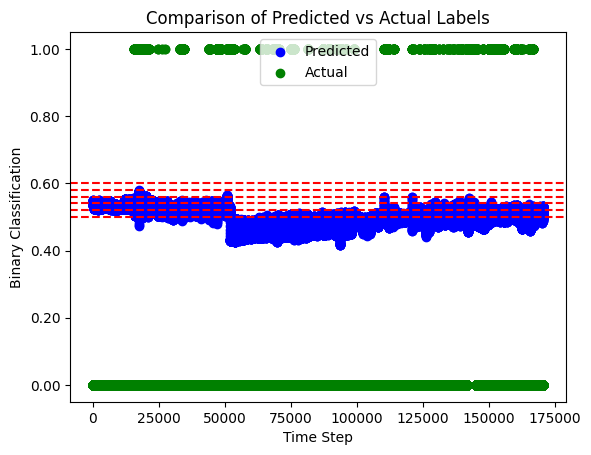

In [52]:

# Build the LSTM model for binary classification
model = Sequential()
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))  # Output layer for binary classification
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Assuming X_data is your DataFrame with 38 sensor columns
X_data_np = X_data.to_numpy()

# Standardize the test data using the same scaler
scaled_X_data = scaler.fit_transform(X_data_np)

# Create sequences for the test data
X_data_sequences = create_sequences(scaled_X_data, sequence_length)

# Use the trained model to predict sequences on the test data
predictions_data = model.predict(X_data_sequences)

# Apply a threshold of 0.5 for binary classification

import matplotlib.pyplot as plt

# Plot predicted values as dots
plt.scatter(range(len(predictions_data)), predictions_data, label='Predicted', color='blue')

# Plot actual labels as dots
plt.scatter(range(len(actual_labels_flat)), actual_labels_flat, label='Actual', color='green')

# Add labels and title
plt.xlabel('Time Step')
plt.ylabel('Binary Classification')
plt.title('Comparison of Predicted vs Actual Labels')
plt.legend()  # Display the legend

# Set y-axis format to display decimal markings
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter("{x:0.2f}"))

# Draw horizontal lines for specific y-axis values
y_values_to_indicate = [0.5, 0.52, 0.54, 0.56, 0.58, 0.6]
for y_value in y_values_to_indicate:
    plt.axhline(y_value, color='red', linestyle='--', label=f'Y={y_value}')

# Show the plot
plt.show()




In [53]:
predictions_data_binary = (predictions_data > 0.54).astype(int)

# Flatten the predictions for comparison
predictions_data_binary_flat = predictions_data_binary.flatten()

# Flatten the actual labels for comparison
actual_labels_flat = X_test.to_numpy().flatten()  # Assuming X_test is the correct label for X_data_np
actual_labels_flat = actual_labels_flat[:-9]  # Assuming the last 9 elements are not part of the test set

# Print counts of 1's and 0's in the predicted binary labels
print("Count of 1's in predictions:", np.sum(predictions_data_binary_flat == 1))
print("Count of 0's in predictions:", np.sum(predictions_data_binary_flat == 0))

# Print the metrics
TP = np.sum((predictions_data_binary_flat == 1) & (actual_labels_flat == 1))
TN = np.sum((predictions_data_binary_flat == 0) & (actual_labels_flat == 0))
FP = np.sum((predictions_data_binary_flat == 1) & (actual_labels_flat == 0))
FN = np.sum((predictions_data_binary_flat == 0) & (actual_labels_flat == 1))

# Print the metrics
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

# Print shapes and values for diagnosis
print("Shapes - predictions_data_binary_flat:", predictions_data_binary_flat.shape, "actual_labels_flat shape:", actual_labels_flat.shape)
print("Values - predictions_data_binary_flat:", predictions_data_binary_flat, "actual_labels_flat values:", actual_labels_flat)

# Calculate accuracy on the test data
accuracy_data = np.sum(predictions_data_binary_flat == actual_labels_flat) / actual_labels_flat.shape[0]

print(f"Test Accuracy on X_data: {accuracy_data * 100:.2f}% ")


Count of 1's in predictions: 6886
Count of 0's in predictions: 163780
True Positives: 1080
True Negatives: 153881
False Positives: 5806
False Negatives: 9899
Shapes - predictions_data_binary_flat: (170666,) actual_labels_flat shape: (170666,)
Values - predictions_data_binary_flat: [0 0 0 ... 0 0 0] actual_labels_flat values: [0 0 0 ... 0 0 0]
Test Accuracy on X_data: 90.80% - Threshold: 0.5
